# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import os
import sys
import glob
import random

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import image from keras correctly based on the TensorFlow version
tf_version = float('.'.join(tf.__version__.split('.')[0:2]))
print(f'Tensorflow version {tf_version}')

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list = os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

Tensorflow version 2.2


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path = prep_data()

# Get lists of training and validation dog and cat images
training_dogs = glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats = glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs = glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats = glob.glob(f'{validation_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Data prep already complete


### 1.2. Inspect

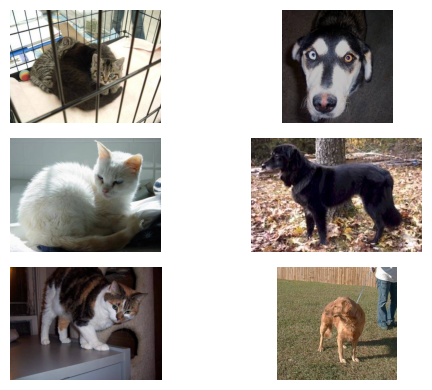

In [3]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal = image.load_img(animal)
        animal = image.img_to_array(animal)
        animal /= 255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 2. EDA

Let's take a deeper look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the dogs
dog = image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog = image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (318, 309, 3)


The data has shape of n x n x 3? The image is n x n pixels, that makes sense. But what is the 3? Let's plot the pixel values and you will see what is going on:

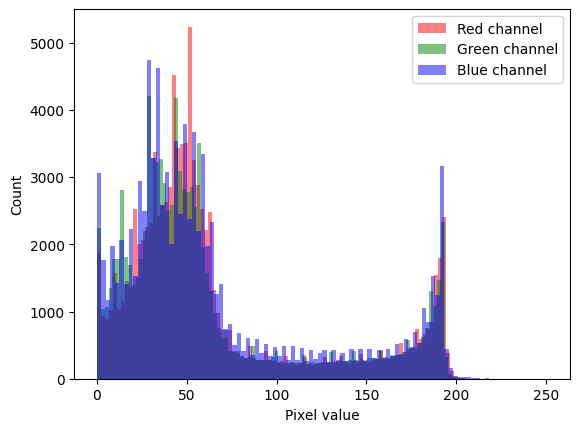

In [5]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: n x n x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue.
2. n x n x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 possible values per pixel. This is defined by the JPEG image standard.

There are two things we can do with this information. First, we should scale the pixel values, this will improve the training of our neural network. We can do this directly in the model definition by adding a normalization layer. Second, we can make the images gray scale, which will decrease the input size and therefore computational burden by a factor of three. We can do this via the image dataset generator.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

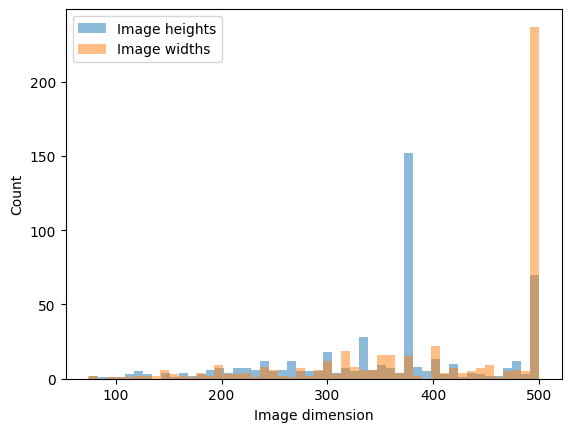

In [6]:
# Get a random sample of images, half cats and half dogs
sample_size = 500
sample = random.sample(training_dogs, sample_size//2)
sample += random.sample(training_cats, sample_size//2)

# Collectors for data
heights = []
widths = []

# Loop on the sample images
for sample_image in sample:

    # Load the image and convert it to an array
    sample_image = image.load_img(sample_image)
    sample_image = image.img_to_array(sample_image)

    # Get the width and height and add to collections
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

# Plot results as a histogram
plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 64 or 128 pixels. Smaller is better for training speed and memory use, but we don't want to go too small, then the model will have a hard time learning from the data. There is no hard and fast rule here. You could do an experiment testing several different image dimensions to see how small we could make the image and still get good performance.

### 2.3. Image aspect ratios

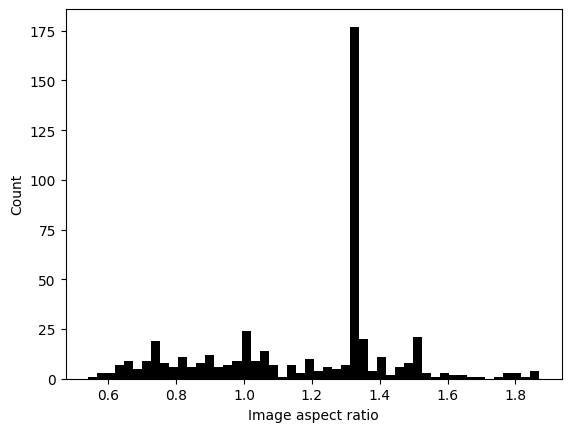

In [7]:
# Calculate the sample image aspect ratios
aspect_ratios = np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

The most common aspect ratio in the data set looks to be around 1.3 - which is the '4:3' aspect ratio that used to be the standard for computer monitors. Rather than using square input images, we can use this aspect ratio to better match the data.

In [8]:
image_width = 64
aspect_ratio = 4/3
image_height=int(image_width / aspect_ratio)

print(f'Input image dimensions: {image_width} x {image_height}')

Input image dimensions: 64 x 48


## 3. Model

Now it's time to build and train the model. We will do this in a few steps, evaluating performance by looking at the training curves along the way:

1. Establish baseline performance with default settings
2. Optimize the batch size and learning rate
3. Optimize regularization with L1 and L2 penalties
4. Optimize input image size for speed and/or better performance
5. Optimize network architecture
6. Final model and evaluation

First, let's choose some initial settings for how much to train.

In [9]:
epochs = 20
steps_per_epoch = 50
validation_steps = 50

### 3.1. Baseline model performance

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


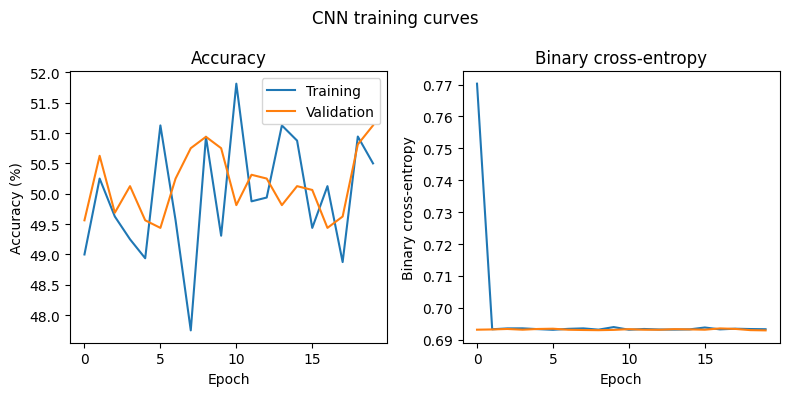


CPU times: user 1.04 s, sys: 483 ms, total: 1.52 s
Wall time: 2.06 s


In [10]:
%%time

# Do a single training run with default settings
training_results = single_training_run(
    training_data_path,
    validation_data_path,
    image_height=image_width,
    image_width=image_height,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    print_model_summary=True
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.2. Batch size and learning rate optimization

Optimization run already complete, loading results from disk.


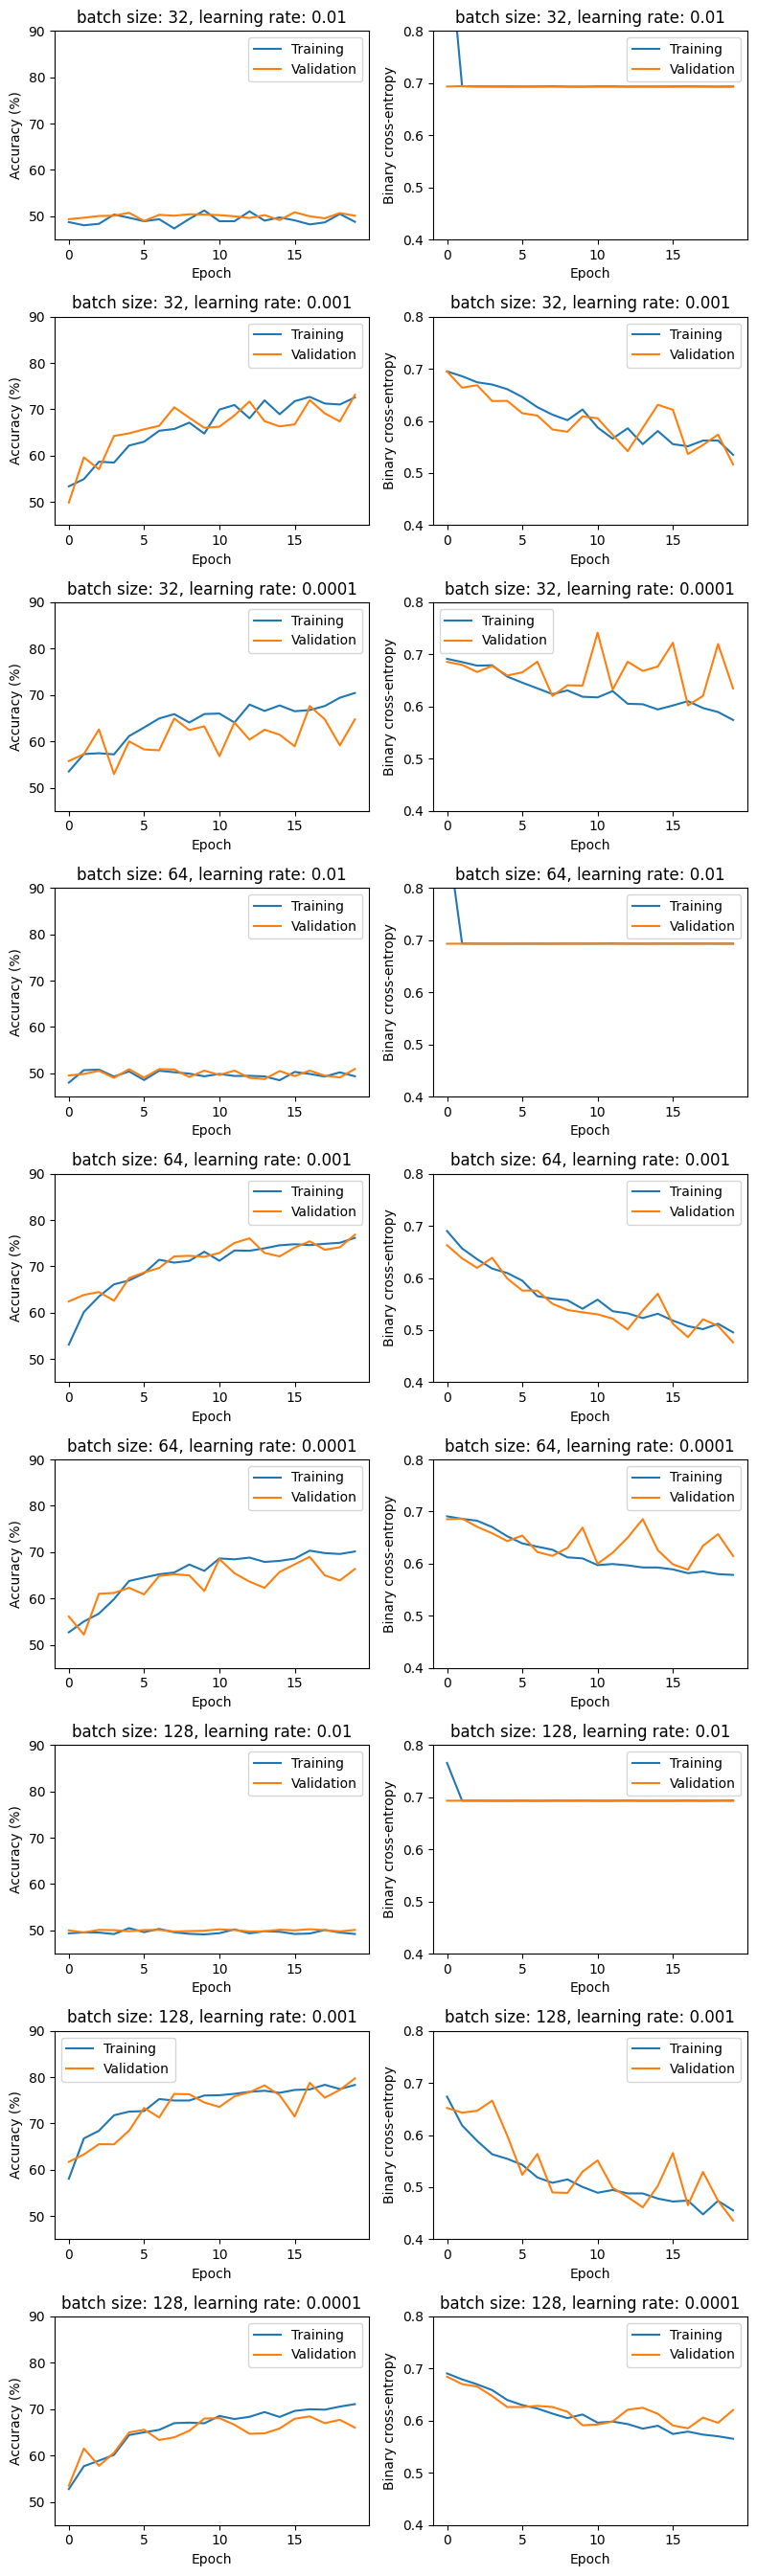


CPU times: user 2.99 s, sys: 142 ms, total: 3.13 s
Wall time: 6.07 s


In [11]:
%%time

# Define hyperparameters
hyperparameters = {
    'batch_sizes': [32, 64, 128],
    'learning_rates': [0.01, 0.001, 0.0001],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results = hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels = ['batch_sizes', 'learning_rates']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.4,0.8]
).show()

print()

In [12]:
batch_size = 64
learning_rate = 0.001
epochs = 100

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Training run already complete, loading results from disk.


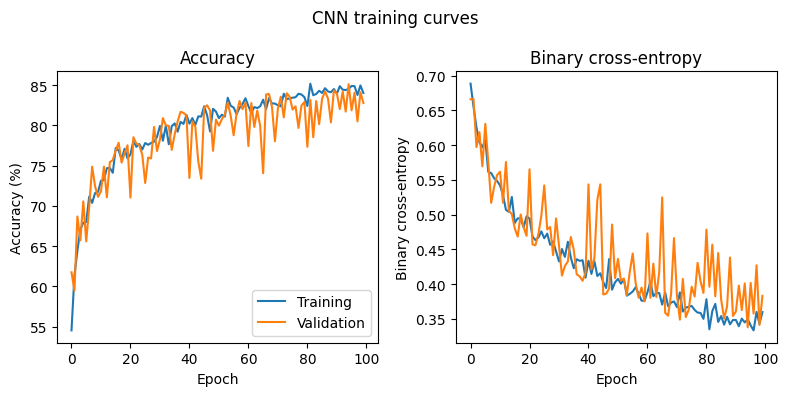


CPU times: user 951 ms, sys: 328 ms, total: 1.28 s
Wall time: 1.64 s


In [13]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'image_width': image_width,
    'image_height': image_height,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.3. Regularization

Optimize L1 and L2 penalties using the optimized batch size and learning rate from the previous experiment.

Starting training run 1 of 4
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Starting training run 2 of 4
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Starting training run 3 of 4
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Starting training run 4 of 4
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


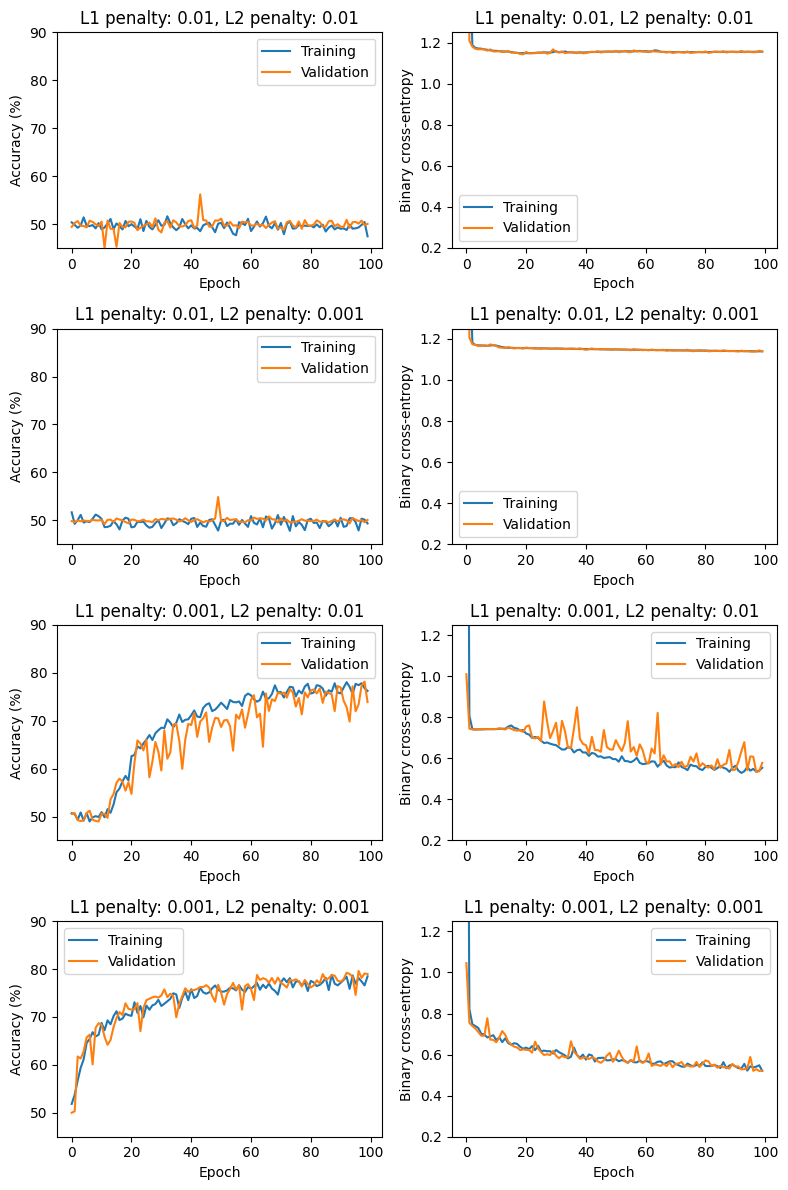


CPU times: user 2h 4min 11s, sys: 3min 4s, total: 2h 7min 16s
Wall time: 1h 41min 31s


In [14]:
%%time

# Define hyperparameters
hyperparameters = {
    'l1_penalties': [0.01, 0.001],
    'l2_penalties': [0.01, 0.001],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results = hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels = ['l1_penalties', 'l2_penalties']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.2,1.25]
).show()

print()

In [15]:
l1_penalty = 0.001
l2_penalty = 0.01
epochs = 200

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


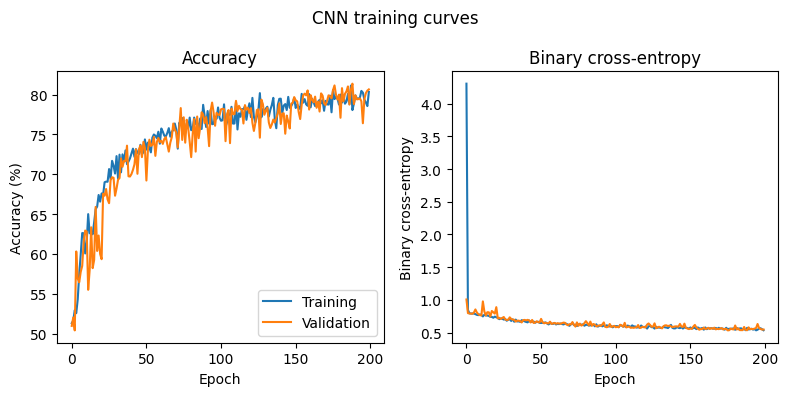


CPU times: user 1h 48min 18s, sys: 2min 26s, total: 1h 50min 44s
Wall time: 1h 4min 24s


In [16]:
%%time

# Set some hyperparameters for the run
hyperparameters = {
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': epochs
}

# Do a single training run
training_results = single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters,
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.4. Input image size optimization

Try some smaller input image sizes and see how the model does with the hyperparameter settings we have chosen via optimization so far.

In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [l1_penalty],
    'l2_penalties': [l2_penalty],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [64, 128, 256],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['image_widths']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.2,1.5]
).show()

print()

Starting training run 1 of 3
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Starting training run 2 of 3
Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
image_width=256
image_height=int(image_width/aspect_ratio)

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 2000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.5. Model architecture

#### 3.5.1. Convolutional layers

In [ ]:
%%time

# Define hyperparameters
hyperparameters={
    'filter_nums_list': [[16,32,64],[32,64,128],[64,128,256]],
    'filter_sizes': [3,4,5],
    'l1_penalties': [l1_penalty],
    'l2_penalties': [l2_penalty],
    'batch_sizes': [batch_size],
    'learning_rates': [learning_rate],
    'image_widths': [image_width],
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 500
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['filter_nums_list', 'filter_sizes']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,95],
    entropy_ylims=[0.9,4.5]
).show()

print()

In [ ]:
filter_nums=[64,128,256]
filter_size=3

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': filter_nums,
    'filter_size': filter_size,
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'image_height': image_height,
    'image_width': image_width,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

## 4. Model performance

### 4.1. Train model with final parameters

In [ ]:
# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': filter_nums,
    'filter_size': filter_size,
    'l1_penalty': l1_penalty,
    'l2_penalty': l2_penalty,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 1000
}

for key, value in hyperparameters.items():
    print(f'{key}: {value}')

In [ ]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': filter_nums,
    'filter_size': filter_size,
    'l1_penalty': 0.002,
    'l2_penalty': 0.0002,
    'image_height': image_height,
    'image_width': image_width,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'epochs': 2000
}

# Do a single training run
training_results=single_training_run(
    training_data_path,
    validation_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 4.2. Testing dataset

In [ ]:
# Get lists of testing dog and cat images
testing_dogs=glob.glob(f'{testing_data_path}/dogs/dog.*')
testing_cats=glob.glob(f'{testing_data_path}/cats/cat.*')

# Plot some of the cat and dog images
fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(testing_cats, testing_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

In [ ]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=False
)

images=np.concatenate([x for x, y in testing_dataset], axis=0)
labels=np.concatenate([y for x, y in testing_dataset], axis=0)

### 4.3. Test set performance

In [ ]:
logits=training_results.model.predict(testing_dataset).flatten()

plt.hist(logits, color='black', bins=30)
plt.show()

In [ ]:
threshold=0.5
predictions=np.array([1 if p > threshold else 0 for p in logits])
labels=np.concatenate([y for x, y in testing_dataset], axis=0)

# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()